Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2449 images belonging to 4 classes.
Found 430 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 69s 804ms/step - accuracy: 0.3710 - auc: 0.6426 - loss: 22.6298 - precision: 0.3933 - recall: 0.3091 - val_accuracy: 0.3317 - val_auc: 0.6881 - val_loss: 19.4140 - val_precision: 1.0000 - val_recall: 0.0024
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.4688 - auc: 0.7402 - loss: 19.4689 - precision: 0.5172 - recall: 0.4688 - val_accuracy: 0.3341 - val_auc: 0.6925 - val_loss: 19.3723 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5606 - auc: 0.8126 - loss: 18.7643 - precision: 0.6038 - recall: 0.5099 - val_accuracy: 0.2933 - val_auc: 0.6773 - val_loss: 17.6788 - val_precision: 0.2968 - val_recall: 0.2933
Epoch 4/

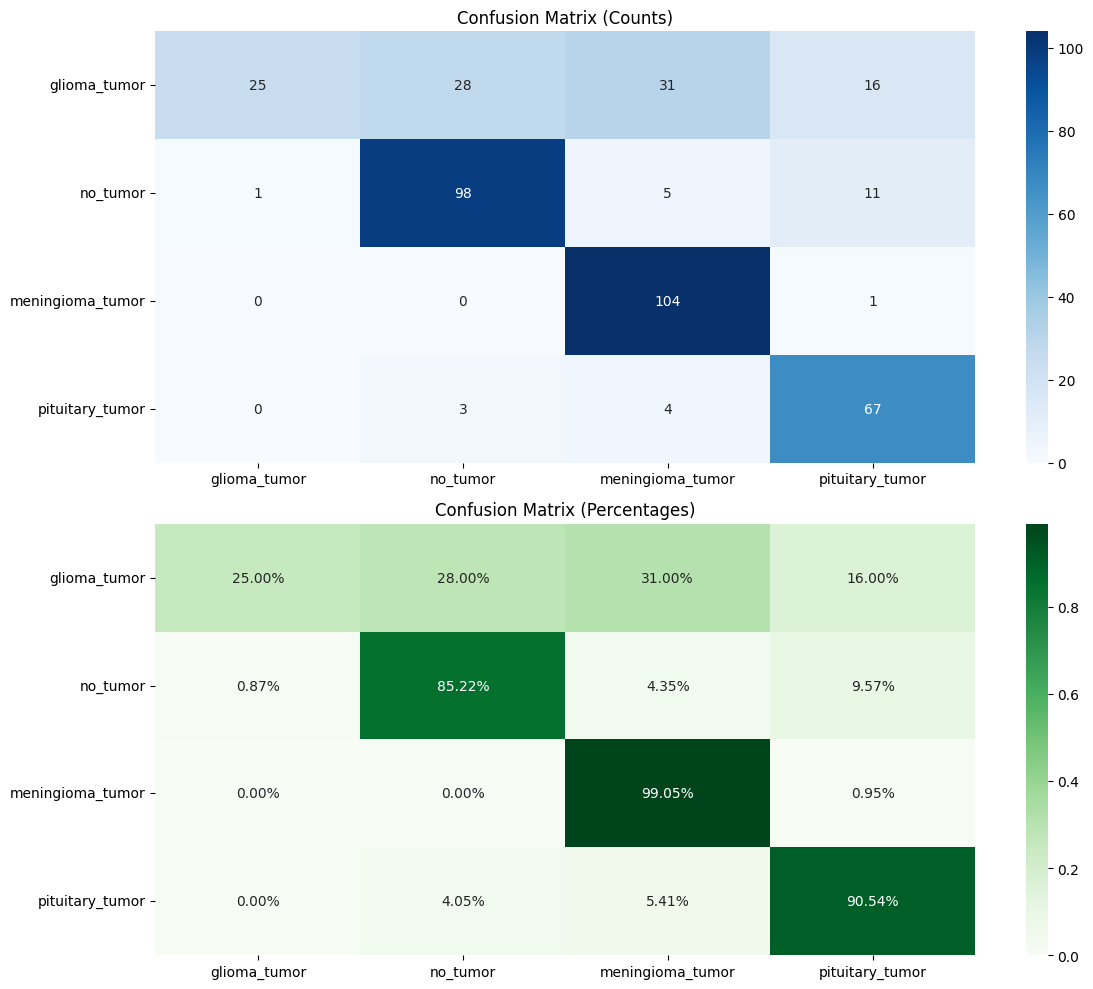

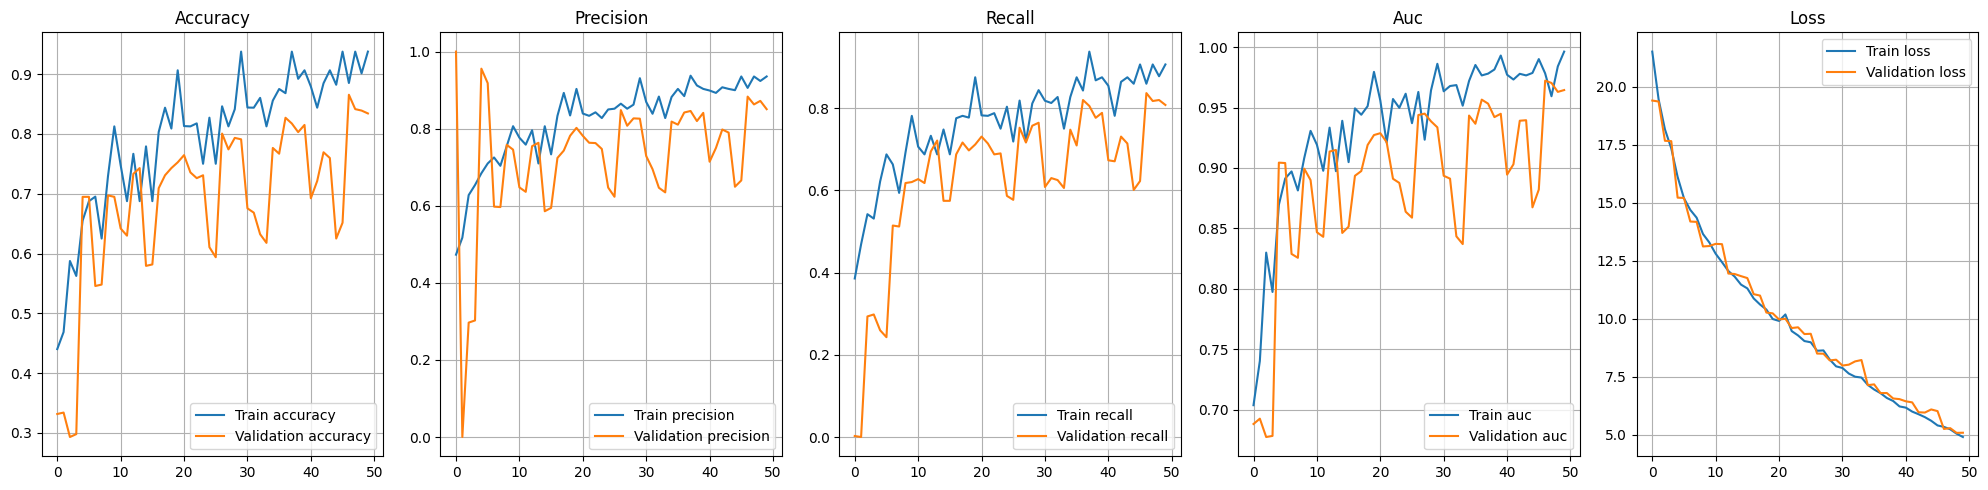


Brain Tumor Classification System
Enter image path (or 'q' to quit): /content/image(7).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


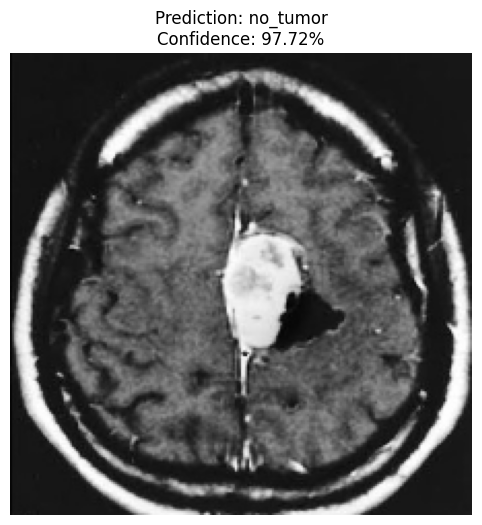


Detailed Prediction Probabilities:
glioma_tumor: 0.27%
no_tumor: 97.72%
meningioma_tumor: 1.93%
pituitary_tumor: 0.08%

Brain Tumor Classification System
Enter image path (or 'q' to quit): /content/image(20).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


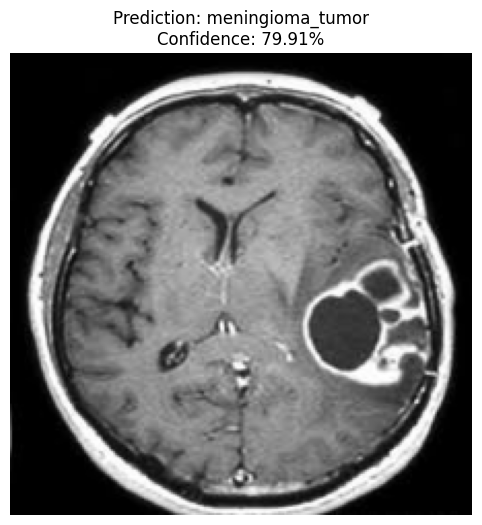


Detailed Prediction Probabilities:
glioma_tumor: 5.46%
no_tumor: 11.83%
meningioma_tumor: 79.91%
pituitary_tumor: 2.79%

Brain Tumor Classification System


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from warnings import filterwarnings

filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
DATA_ROOT = '/content/drive/MyDrive/MRI'
TRAIN_DIR = os.path.join(DATA_ROOT, 'Training')
TEST_DIR = os.path.join(DATA_ROOT, 'Testing')

# Verify paths
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found at {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found at {TEST_DIR}")

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
image_size = 224  # VGG16 input size

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Class weights
train_classes = train_generator.classes
class_weights = compute_class_weight('balanced',
                                    classes=np.unique(train_classes),
                                    y=train_classes)
class_weights = dict(enumerate(class_weights))

# Model architecture
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Freeze layers
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Optimizer with learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Callbacks (removed ReduceLROnPlateau)
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

model_checkpoint = ModelCheckpoint(
    'best_vgg16_model.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

csv_logger = CSVLogger('training_log.csv')

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint, csv_logger],
    verbose=1,
    class_weight=class_weights
)

# Load best model
model = tf.keras.models.load_model('best_vgg16_model.keras')

# Evaluation
print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

test_results = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_results[2]*100:.2f}%")
print(f"Test Recall: {test_results[3]*100:.2f}%")
print(f"Test AUC: {test_results[4]*100:.2f}%")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(f"\nOverall Model Accuracy: {accuracy*100:.2f}%")
print(f"Weighted Precision: {precision*100:.2f}%")
print(f"Weighted Recall: {recall*100:.2f}%")
print(f"Weighted F1-Score: {f1*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
conf_mat_percent = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Counts)')

plt.subplot(2, 1, 2)
sns.heatmap(conf_mat_percent, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Percentages)')

plt.tight_layout()
plt.show()

# Training history
plt.figure(figsize=(20, 5))
metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']
for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i+1)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Prediction function
def predict_tumor(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError

        img = cv2.resize(img, (image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = np.expand_dims(img, axis=0) / 255.0

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)
        predicted_label = labels[predicted_class]
        confidence = predictions[0][predicted_class]

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence*100:.2f}%")
        plt.show()

        print(f"\nDetailed Prediction Probabilities:")
        for label, prob in zip(labels, predictions[0]):
            print(f"{label}: {prob*100:.2f}%")

    except FileNotFoundError:
        print("Error: Image not found or path is incorrect.")

# Prediction loop
while True:
    print("\n" + "="*50)
    print("Brain Tumor Classification System")
    image_path = input("Enter image path (or 'q' to quit): ")

    if image_path.lower() == 'q':
        break

    predict_tumor(image_path)